In [1]:
# Mounting the drive to load the data from drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/NLP assignment3/'

/content/drive/MyDrive/NLP assignment3


In [3]:
import pandas as pd

# Update the path if needed
df = pd.read_csv('/content/drive/MyDrive/NLP assignment3/fomc_transcripts_cleaned.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna(subset=['Content'])


In [4]:
df


,URL,Date,Year,Month,Day,Source,Content,cleaned_text
0,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,2025,3,19,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...
1,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,2025,3,19,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...
2,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,2025,3,19,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...
3,https://www.federalreserve.gov/monetarypolicy/...,2025-01-29,2025,1,29,Main Calendar,Please enable JavaScript if it is disabled in ...,please enable javascript if it is disabled in ...
4,https://www.federalreserve.gov/monetarypolicy/...,2025-01-29,2025,1,29,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...
...,...,...,...,...,...,...,...,...
123,https://www.federalreserve.gov/monetarypolicy/...,2015-06-17,2015,6,17,Historical Archive,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...
124,https://www.federalreserve.gov/monetarypolicy/...,2015-04-29,2015,4,29,Historical Archive,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...
125,https://www.federalreserve.gov/monetarypolicy/...,2015-03-18,2015,3,18,Historical Archive,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...
126,https://www.federalreserve.gov/monetarypolicy/...,2015-03-18,2015,3,18,Historical Archive,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...


Sorting the Date and Index

In [5]:
import pandas as pd

# 1) Convert the 'Date' column from object (string) to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 2) (Optional) Drop or inspect rows where conversion failed
# print(df[df['Date'].isna()])

# 3) Sort the DataFrame by the new datetime 'Date' column in descending order
df = df.sort_values(by='Date', ascending=False)

# 4) (Optional) Reset index if you want a clean integer index
df = df.reset_index(drop=True)

# Now df['Date'] is a datetime dtype and the rows are sorted newest → oldest
#print(df[['doc_id', 'Date']].head())


In [6]:
# 1) Make sure your index is reset 0…N‑1
df = df.reset_index(drop=True)

# 2) Rebuild doc_id as "doc1", "doc2", … up to "docN"
df['doc_id'] = 'doc' + (df.index + 1).astype(str)

# 3) Check
print(df[['doc_id', 'Date']].head())


  doc_id       Date
0   doc1 2025-03-19
1   doc2 2025-03-19
2   doc3 2025-03-19
3   doc4 2025-01-29
4   doc5 2025-01-29


In [7]:
import spacy
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# 1) Load spaCy model for sentence splitting
nlp = spacy.load("en_core_web_sm")

# 2) Build analysis DataFrame with text and Date columns
df_analysis = pd.DataFrame({
    "text": df["cleaned_text"],
    "Date": pd.to_datetime(df["Date"]).dt.date  # convert to date only
})

# 3) Function to compute sentence, word, token, and chunk metrics
def compute_bert_metrics(text):
    doc = nlp(text)
    total_sentences = len(list(doc.sents))
    total_words     = sum(len([t for t in sent if not t.is_space]) for sent in doc.sents)
    bert_tokens     = total_words * 0.75
    bert_chunks_450 = int(np.ceil(bert_tokens / 450))
    return total_sentences, total_words, round(bert_tokens, 1), bert_chunks_450

# 4) Apply metrics function and expand into separate columns
df_analysis[
    ["total_sentences", "total_words", "bert_tokens", "bert_chunks_450"]
] = pd.DataFrame(
    df_analysis["text"]
        .apply(compute_bert_metrics)
        .tolist(),
    index=df_analysis.index
)

# 5) Prepare heatmap data
metrics  = ["total_sentences", "total_words", "bert_tokens", "bert_chunks_450"]
z        = df_analysis[metrics].values
z_text   = [[str(val) for val in row] for row in z]
x_labels = metrics
y_labels = [f"Doc {i+1} ({date})" for i, date in enumerate(df_analysis["Date"])]

# 6) Build and display the heatmap with values and clean dates
fig = go.Figure(data=go.Heatmap(
    z=z,
    x=x_labels,
    y=y_labels,
    text=z_text,                # display each cell's value
    texttemplate="%{text}",     # template for cell text
    colorscale="Viridis",
    colorbar=dict(title="Value")
))

# 7) Reverse y-axis so that Doc1 appears at the top
fig.update_yaxes(autorange="reversed")

# 8) Layout tweaks
fig.update_layout(
    title="📊 BERT-Based Document Metrics",
    xaxis_title="Metrics",
    yaxis_title="Document (Date)",
    height=600,
    width=800,
    margin=dict(l=00)  # make space for longer y-labels
)

fig.show()


In [8]:
df

,URL,Date,Year,Month,Day,Source,Content,cleaned_text,doc_id
0,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,2025,3,19,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc1
1,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,2025,3,19,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc2
2,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,2025,3,19,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc3
3,https://www.federalreserve.gov/monetarypolicy/...,2025-01-29,2025,1,29,Main Calendar,Please enable JavaScript if it is disabled in ...,please enable javascript if it is disabled in ...,doc4
4,https://www.federalreserve.gov/monetarypolicy/...,2025-01-29,2025,1,29,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc5
...,...,...,...,...,...,...,...,...,...
123,https://www.federalreserve.gov/monetarypolicy/...,2015-06-17,2015,6,17,Historical Archive,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc124
124,https://www.federalreserve.gov/monetarypolicy/...,2015-04-29,2015,4,29,Historical Archive,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc125
125,https://www.federalreserve.gov/monetarypolicy/...,2015-03-18,2015,3,18,Historical Archive,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc126
126,https://www.federalreserve.gov/monetarypolicy/...,2015-03-18,2015,3,18,Historical Archive,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc127


In [9]:
!pip install --upgrade transformers

In [10]:
import transformers
print(transformers.__version__)

4.51.3


In [11]:
!pip install --upgrade torch
!pip install --upgrade spacy

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/index_command.py", line 71, in get_default_session
    self._session = self.enter_context(self._build_session(options))
                                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/index_command.py", line 100, in _build_session
    session = 

In [12]:
nlp = spacy.load("en_core_web_sm")

In [13]:
!pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

!pip install bert-score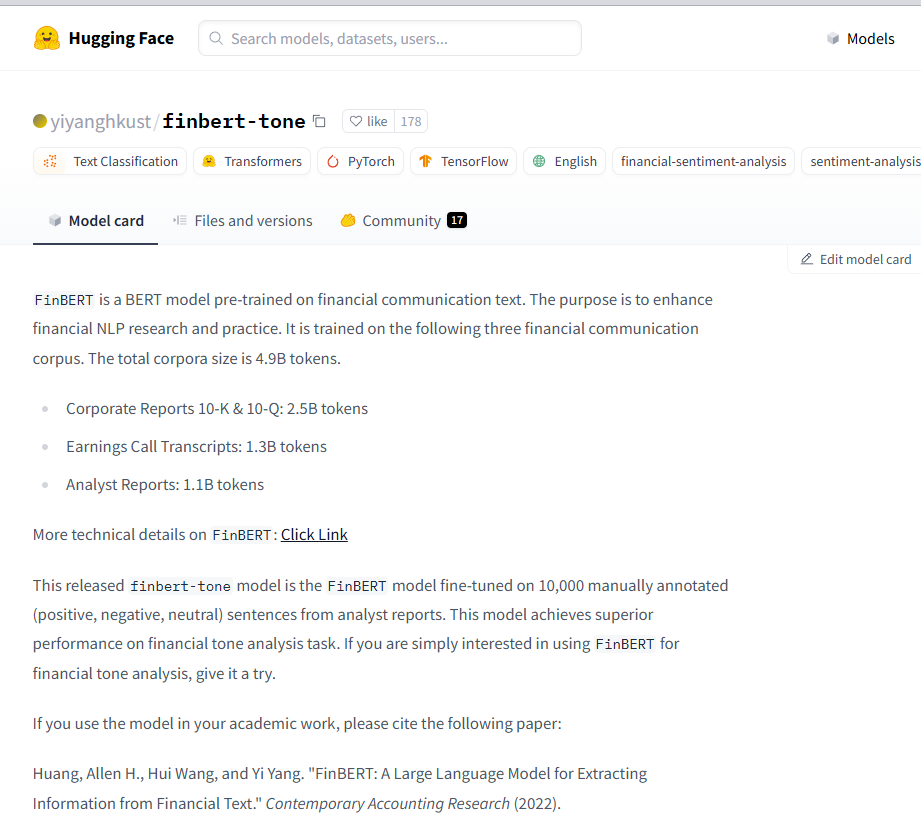

Loading the model and the tokenizer

Imports & Model Loading (yiyanghkust/finbert-tone)

In [14]:
import spacy
import torch
from transformers import AutoTokenizer, AutoModel

# 1) spaCy for sentence splitting
nlp = spacy.load("en_core_web_sm")

# 2) FinBERT‑Tone for financial‑domain embeddings
TOKENIZER = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
FINBERT    = AutoModel.from_pretrained("yiyanghkust/finbert-tone")

# 3) Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FINBERT.to(DEVICE).eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30873, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Chunking into ~450‑token windows with 100‑token overlap

In [15]:
def chunk_text(text, max_tokens=450, overlap=100):
    doc = nlp(text)
    sents = [sent.text.strip() for sent in doc.sents]

    chunks = []
    curr, curr_count = [], 0

    for sent in sents:
        toks = TOKENIZER.tokenize(sent)
        n = len(toks)
        # if adding this sentence would overflow, finalize current chunk
        if curr_count + n > max_tokens:
            chunks.append(" ".join(curr))
            # build overlap window
            overlap_sents, count = [], 0
            for prev in reversed(curr):
                ptoks = TOKENIZER.tokenize(prev)
                if count + len(ptoks) > overlap:
                    break
                overlap_sents.insert(0, prev)
                count += len(ptoks)
            curr, curr_count = overlap_sents, count

        curr.append(sent)
        curr_count += n

    if curr:
        chunks.append(" ".join(curr))
    return chunks


Extract unique sentences from all chunks

In [16]:
def sentences_from_chunks(chunks):
    seen = set()
    sentences = []
    for chunk in chunks:
        for sent in nlp(chunk).sents:
            t = sent.text.strip()
            if t not in seen:
                seen.add(t)
                sentences.append(t)
    return sentences

Get [CLS] embeddings via FinBERT

In [17]:
@torch.no_grad()
def embed_sentences(sent_list):
    embs = []
    for s in sent_list:
        inputs = TOKENIZER(
            s,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=512
        ).to(DEVICE)
        out = FINBERT(**inputs)
        cls = out.last_hidden_state[:, 0, :].cpu().numpy()
        embs.append(cls.squeeze(0))
    return np.vstack(embs)

MMR‐based selection up to ~1500 tokens

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

def mmr_summary(sents, embs, doc_emb, max_tokens=1500, lam=0.6):
    selected, sel_embs, used = [], [], set()
    cur_toks = 0
    doc_sim = cosine_similarity(embs, doc_emb.reshape(1, -1)).flatten()

    while used != set(range(len(sents))) and cur_toks < max_tokens:
        scores = {}
        for idx in set(range(len(sents))) - used:
            rel = doc_sim[idx]
            div = max(cosine_similarity(
                embs[idx:idx+1],
                np.vstack(sel_embs) if sel_embs else embs[idx:idx+1]
            ).flatten()) if sel_embs else 0.0
            scores[idx] = lam * rel - (1 - lam) * div

        best = max(scores, key=scores.get)
        tok_len = len(TOKENIZER.tokenize(sents[best]))
        if cur_toks + tok_len > max_tokens:
            break

        selected.append(sents[best])
        sel_embs.append(embs[best])
        used.add(best)
        cur_toks += tok_len

    return " ".join(selected)


In [26]:
df

,URL,Date,Year,Month,Day,Source,Content,cleaned_text,doc_id,original_length
0,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,2025,3,19,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc1,139
1,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,2025,3,19,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc2,7337
2,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,2025,3,19,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc3,4300
3,https://www.federalreserve.gov/monetarypolicy/...,2025-01-29,2025,1,29,Main Calendar,Please enable JavaScript if it is disabled in ...,please enable javascript if it is disabled in ...,doc4,121
4,https://www.federalreserve.gov/monetarypolicy/...,2025-01-29,2025,1,29,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc5,8229
...,...,...,...,...,...,...,...,...,...,...
123,https://www.federalreserve.gov/monetarypolicy/...,2015-06-17,2015,6,17,Historical Archive,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc124,8192
124,https://www.federalreserve.gov/monetarypolicy/...,2015-04-29,2015,4,29,Historical Archive,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc125,7732
125,https://www.federalreserve.gov/monetarypolicy/...,2015-03-18,2015,3,18,Historical Archive,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc126,134
126,https://www.federalreserve.gov/monetarypolicy/...,2015-03-18,2015,3,18,Historical Archive,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc127,8648


Full pipeline and store in df["summary"]

In [30]:
import numpy as np

def summarize(text):
    chunks   = chunk_text(text)
    sents    = sentences_from_chunks(chunks)
    embs     = embed_sentences(sents)
    doc_emb  = embs.mean(axis=0)
    return mmr_summary(sents, embs, doc_emb)

# apply to your DataFrame
df["summary"] = df["cleaned_text"].apply(summarize)

In [31]:
df


,URL,Date,Year,Month,Day,Source,Content,cleaned_text,doc_id,original_length,summary
0,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,2025,3,19,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc1,139,decrease volume m toggles mute on off f toggle...
1,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,2025,3,19,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc2,7337,as a result participants generally saw increas...
2,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,2025,3,19,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc3,4300,â .december projection ..... however the forec...
3,https://www.federalreserve.gov/monetarypolicy/...,2025-01-29,2025,1,29,Main Calendar,Please enable JavaScript if it is disabled in ...,please enable javascript if it is disabled in ...,doc4,121,please enable javascript if it is disabled in ...
4,https://www.federalreserve.gov/monetarypolicy/...,2025-01-29,2025,1,29,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc5,8229,the risks around the baseline projection for i...
...,...,...,...,...,...,...,...,...,...,...,...
123,https://www.federalreserve.gov/monetarypolicy/...,2015-06-17,2015,6,17,Historical Archive,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc124,8192,there were no intervention operations in forei...
124,https://www.federalreserve.gov/monetarypolicy/...,2015-04-29,2015,4,29,Historical Archive,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc125,7732,the pace of job gains had moderated and the un...
125,https://www.federalreserve.gov/monetarypolicy/...,2015-03-18,2015,3,18,Historical Archive,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc126,134,decrease volume m toggles mute on off f toggle...
126,https://www.federalreserve.gov/monetarypolicy/...,2015-03-18,2015,3,18,Historical Archive,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...,doc127,8648,while the tightening of spreads was broad base...


In [34]:
output_path = "/content/drive/MyDrive/NLP assignment3/FOMC_Summary_Analysis.csv"

df.to_csv(output_path, index=False)
print(f"✅ File saved to: {output_path}")

✅ File saved to: /content/drive/MyDrive/NLP assignment3/FOMC_Summary_Analysis.csv


In [35]:
df["summary_length"] = df["summary"].apply(lambda x: len(str(x).split()))
df["compression_ratio"] = df["summary_length"] / df["original_length"]

In [45]:
import plotly.express as px

fig1 = px.line(
    df,
    x="Date",
    y="compression_ratio",
    title="Compression Ratio Over Time (FinBERT Summary)",
    labels={"compression_ratio": "Summary / Original Length"},
    markers=True
)
fig1.update_layout(template="plotly_white")
fig1.show()


In [44]:
fig2 = px.line(
    df,
    x="Date",
    y=["summary_length", "original_length"],
    title=" Summary vs Original Document Length Over Time",
    labels={"value": "Word Count", "variable": "Text Type"},
    markers=True
)
fig2.update_layout(template="plotly_white")
fig2.show()


In [43]:
fig3 = px.histogram(
    df,
    x="compression_ratio",
    nbins=30,
    title=" Distribution of Compression Ratios",
    labels={"compression_ratio": "Summary / Original Length"}
)
fig3.update_layout(template="plotly_white")
fig3.show()


In [39]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

heat_data = df.groupby(['Year', 'Month'])['summary_length'].mean().reset_index()
fig = px.density_heatmap(
    heat_data,
    x='Month',
    y='Year',
    z='summary_length',
    title="📅 Average Summary Length by Month and Year",
    labels={'summary_length': 'Avg Summary Length'},
    nbinsx=12,
    color_continuous_scale='Viridis'
)
fig.update_layout(template="plotly_white")
fig.show()


In [42]:
df_sorted = df.sort_values("Date").reset_index(drop=True)
df_sorted["summary_ma_rolling"] = df_sorted["summary_length"].rolling(window=5).mean()

fig = px.line(
    df_sorted,
    x="Date",
    y="summary_ma_rolling",
    title="📈 5-Meeting Rolling Average of Summary Length",
    labels={"summary_ma_rolling": "Rolling Avg Summary Length"}
)
fig.update_layout(template="plotly_white")
fig.show()
